# Manufacturing
## Time to failure since repair

In manufacturing machine failure means less production, potentially unforeseen expenses, and consequently less revenue. Hence as a manufacturer we want to find ways to predict and reduce machine failure. This can be achieved by estimating *time to failure since repair*. 

Imagine a car. Throughout its lifetime it undergoes a series of repairs. Each time it undergoes a repair it becomes censored, and we restart the clock. At some point in this cycle the car may finally break (face the event). 

TIME = 0 ###### TIME = 75 CLUTCH CHANGE (BECOMES CENSORED)\
TIME = 0 ############ TIME = 150 TRANSMISSION CHANGE (BECOMES CENSORED)\
TIME = 0 #################### TIME = 200 MOTOR CHANGE (BECOMES CENSORED)\
TIME = 0 ########## TIME = 100 BEYOND REPAIR (EVENT REACHED)

Some cars don't break after, e.g. 10 years, and you get a new one (they are "cured"). 

We can estimate time to failure since repair using apd-crs, incorporating the idea that some machines are resilient and don’t fail before they’re replaced.


## Imports 

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.preprocessing import OneHotEncoder
from apd_crs.survival_analysis import SurvivalAnalysis
from apd_crs.datasets import load_manufacturing


## Using the SurvivalAnalysis Class: Get Labels

In [33]:
# Instantiate the SurvivalAnalysis class and get labels
model = SurvivalAnalysis()
cure_label = model.get_cure_label()
noncure_label = model.get_non_cure_label()
censor_label = model.get_censor_label()


## The manufacturing dataset

- For illustration we use the following data set borrowed from the PySurvival library. 
- A manufacturing plant may have several machines of a certain type. 
- Each machine instance can undergo many repairs over the course of its tenure. 
- This would lead to a multitude of censored observations for time since repair, with each specific machine likely contributing to several observations, since it may be repaired more than once during its tenure.
- Each machine has associated covariates like pressure index, moisture index, the team working with it, etc.
- After preprocessing the data, we would obtain a table like the one below.


We investigate on a dataset from the PySurvival library https://square.github.io/pysurvival/tutorials/maintenance.html

In [34]:
dataset = load_manufacturing()  # load the data


In [35]:
data, labels, times = dataset.data, dataset.target, dataset.target_times
# Load the covariates, labels (censored or not), and times


## Data Preprocessing


In [36]:
# Convert object columns to categorical so we can us sksurv one-hot encoder
for col in ["team", "provider"]:
    data[col] = data[col].astype("category")


In [37]:
# Test train split: To evaluate test performance we split the data into training and testing data;
# test_size is percentage going to test data
from sklearn.model_selection import train_test_split

(
    training_data,
    test_data,
    training_labels,
    test_labels,
    training_times,
    test_times,
) = train_test_split(data, labels, times, test_size=0.33)


In [38]:
# Perform one-hot encoding
from sksurv.preprocessing import OneHotEncoder

ohc = OneHotEncoder()
training_data = ohc.fit_transform(training_data)
test_data = ohc.transform(test_data)


In [39]:
# Scale covariates: Baseline Hazard estimation is parametric so scaling helps with convergence
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
test_data = scaler.transform(test_data)


In [40]:
# Scale times: Baseline Hazard estimation is parametric so scaling helps with convergence

training_times = training_times / training_times.max()
test_times = test_times / training_times.max()


## Using the SurvivalAnalysis Class: Model Fitting

In [41]:
# Instantiate the SurvivalAnalysis class
model = SurvivalAnalysis("clustering")
#'clustering' means we will use clustering to impute cure labels for censored data, followed by
# estimating cure probability with logistic regression


In [42]:
model.survival_fit(
    training_data, training_labels, training_times, surv_reg_term=0.25, pu_kmeans_init=20
)
# surv_reg_term controls regularization for the fitting of lifetime parameters
# pu_kmeans_init is number of Kmeans initializations to try since the estimator is clustering here


## Evaluating Model Performance

### Danger 

The Danger associated with an individual is a measure of the individual's risk 

of facing the event. It can take on any real number.

The higher the Danger, the riskier the individual. E.g. an individual with 

Danger -1.2 is less at risk than one with Danger 1.0.

More precisely, the danger associated with an individual having covariate vector $x$ is

$\mbox{Danger}(x) = w_1 (\gamma\cdot x )+ w_2 \log(1-\pi(x))$ 

where $w_1, w_2$ are weights in the unit interval $[0,1]$ which sum to 1,

$\pi(x)$ is the probability of cure, and $\gamma$ is the parameter vector associated with 

the Hazard of the susceptible (non-cured) population. 

Optimal weights can be chosen through cross validation.

### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. 

A pair of individuals is concordant if the one which "died" first has a higher danger.

C-Index = ratio of concordant pairs to comparable pairs.

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

### Danger Calculation

In [43]:
train_danger = np.dot(training_data, model.gamma_) + np.log(
    model.predict_cure_proba(training_data, training_labels)[:, 1]
)


In [44]:
test_danger = np.dot(test_data, model.gamma_) + np.log(
    model.predict_cure_proba(test_data, test_labels)[:, 1]
)


### C-Index Calculation

In [45]:
train_score = model.cindex(training_times, training_labels, train_danger)

print(f"c-index score on train set is {train_score}")


c-index score on train set is 0.9149149639055426


In [46]:
test_score = model.cindex(test_times, test_labels, test_danger)

print(f"c-index score on test set is {test_score}")


c-index score on test set is 0.8981555733761026


## Overall Risk Factors

<AxesSubplot:>

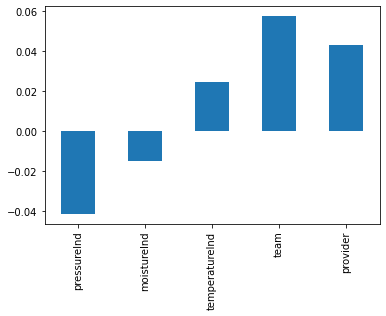

In [47]:
# By plotting the coefficients coming from the proportional Hazard, we can measure
# overall covariate contributions

features = [col for col in data.columns if col not in ["broken", "time_since_repair"]]
feats = {col: model.gamma_[i] for (i, col) in enumerate(features)}
feats = pd.Series(feats)
feats.plot.bar()


## Individual Predictions

In [48]:
# Overall survivor function:

# We can plot the overall survival function for e.g. the first five individuals in the test set.

TIMES = np.arange(1, 93, 0.5)
repeats_array = np.tile(TIMES, (len(test_data), 1))
ovpr = model.predict_overall_survival(test_data, repeats_array, test_labels)

# We can include the corresponding probabilities of cure in a legend
cure_probs = [
    np.around((model.predict_cure_proba(test_data, test_labels)[0:5, 0])[i], decimals=2)
    for i in range(5)
]


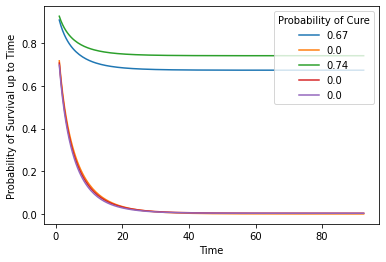

In [49]:
import matplotlib.pyplot as plt

y = ovpr[0:5, :]
x = TIMES
plt.plot(
    x,
    y.T,
)
plt.xlabel("Time")
plt.ylabel("Probability of Survival up to Time")
plt.legend(labels=cure_probs, loc="upper right", title="Probability of Cure")
plt.show()
